In [2]:
import sys ; sys.path.append("../") # osx
import cvlib

In [3]:
path = '/Users/carlosalvarado/Desktop/ComputerVision/fotos/'

In [4]:
#cvlib.core

In [5]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline
import random as rng
rng.seed(20)

In [6]:
img = 255* np.array([[0,0,0,0,0,0,0,0],
                    [0,1,1,1,1,1,0,0],
                    [0,1,0,0,0,1,1,0],
                    [0,1,0,0,0,1,1,0],
                    [0,1,0,0,1,1,0,0],
                    [0,1,1,1,1,1,0,0],
                    [0,0,0,0,0,0,0,0],
                    [0,0,0,0,0,0,0,0]],dtype=np.uint8)

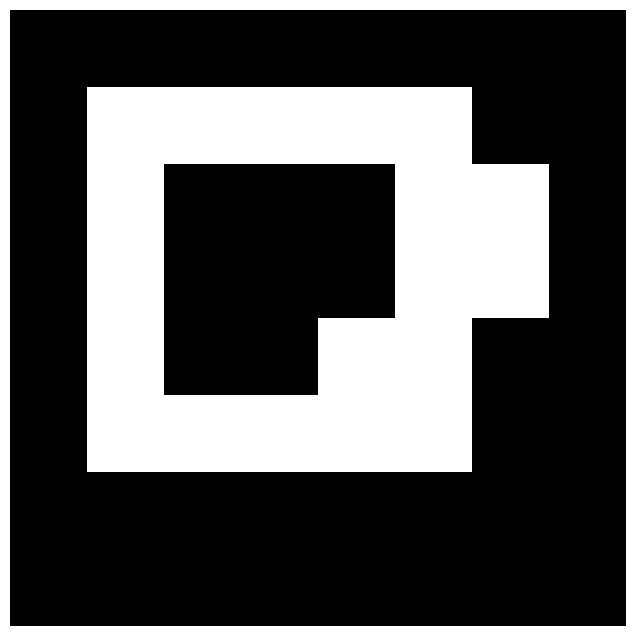

In [7]:
cvlib.imgview(img)

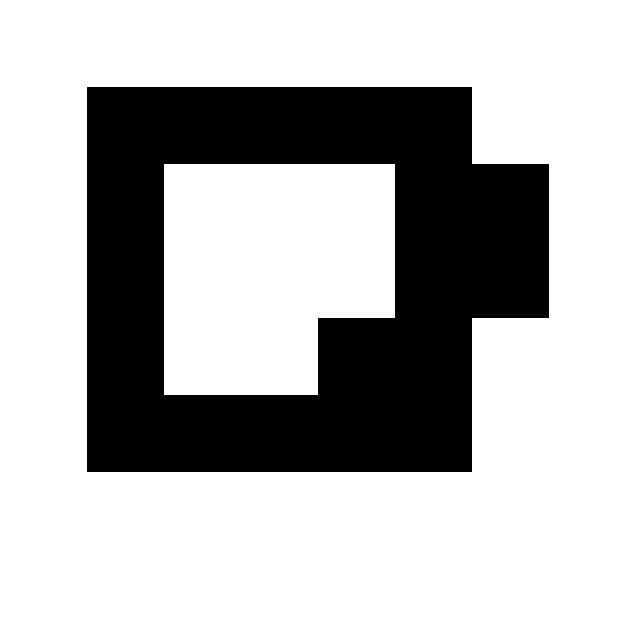

In [8]:
imgc= 255 - img
cvlib.imgview(imgc)

In [9]:
fill = np.zeros(img.shape,dtype=np.uint8)

In [10]:
r, c = img.shape

for i in range(r):
    for j in range(c):
        if img[i,j]>0:
            print(i,j)
            n=img[-1+i:i+2,-1+j:j+2]
#             n = n.ravel()
            print(n)
            print()
    print()


1 1
[[  0   0   0]
 [  0 255 255]
 [  0 255   0]]

1 2
[[  0   0   0]
 [255 255 255]
 [255   0   0]]

1 3
[[  0   0   0]
 [255 255 255]
 [  0   0   0]]

1 4
[[  0   0   0]
 [255 255 255]
 [  0   0 255]]

1 5
[[  0   0   0]
 [255 255   0]
 [  0 255 255]]


2 1
[[  0 255 255]
 [  0 255   0]
 [  0 255   0]]

2 5
[[255 255   0]
 [  0 255 255]
 [  0 255 255]]

2 6
[[255   0   0]
 [255 255   0]
 [255 255   0]]


3 1
[[  0 255   0]
 [  0 255   0]
 [  0 255   0]]

3 5
[[  0 255 255]
 [  0 255 255]
 [255 255   0]]

3 6
[[255 255   0]
 [255 255   0]
 [255   0   0]]


4 1
[[  0 255   0]
 [  0 255   0]
 [  0 255 255]]

4 4
[[  0   0 255]
 [  0 255 255]
 [255 255 255]]

4 5
[[  0 255 255]
 [255 255   0]
 [255 255   0]]


5 1
[[  0 255   0]
 [  0 255 255]
 [  0   0   0]]

5 2
[[255   0   0]
 [255 255 255]
 [  0   0   0]]

5 3
[[  0   0 255]
 [255 255 255]
 [  0   0   0]]

5 4
[[  0 255 255]
 [255 255 255]
 [  0   0   0]]

5 5
[[255 255   0]
 [255 255   0]
 [  0   0   0]]






# FILL HOLES AND WATESHED

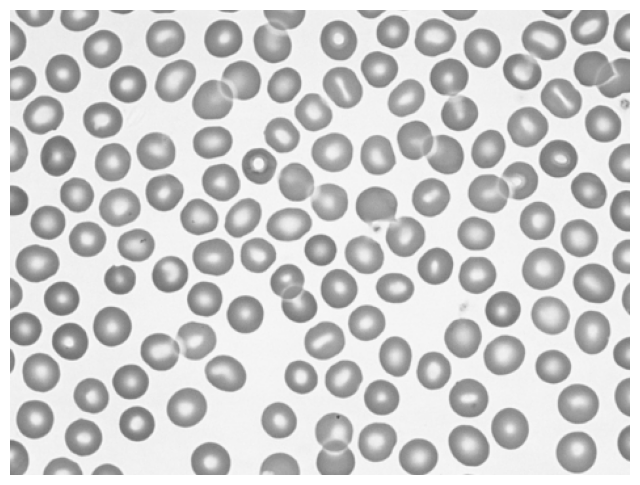

In [11]:
img = cv.imread(path+ 'cells.png',cv.IMREAD_COLOR)
img_bw = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
cvlib.imgview(img)

el blur significa que queremos quitar detalles que me van a hacer ruido

In [12]:
k = 5
img_blur = cv.GaussianBlur(img_bw,(k,k),0)
cv.normalize(img_blur, img_blur, 0, 255.0, cv.NORM_MINMAX)
img_bin = 255- cv.adaptiveThreshold(img_blur, 255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,3,2)

k = 3
kernel = cv.getStructuringElement(cv.MORPH_ELLIPSE,(k,k))
img_bin = cv.dilate(img_bin, kernel, iterations=2)

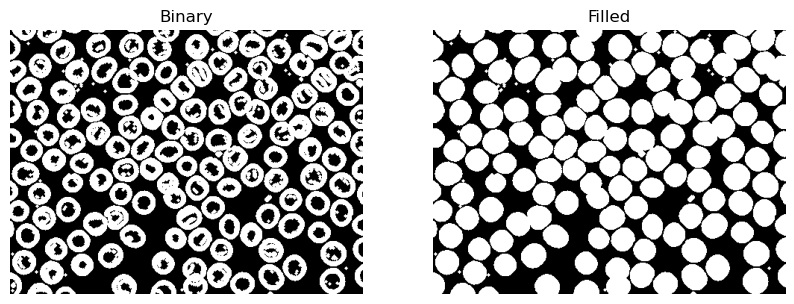

In [13]:
def fill_holes(img_bin):
    """ Fill holes in binary image usign FloodFill.
    
    Args:
        - img_bin (numpy array): Binary image to fill
    Returns:
        - filled (numpy array): Binary image with filled holes
    """

    h, w = img_bin.shape[:2]
    mask = np.zeros((h+2, w+2), np.uint8)
     
    img_fl = img_bin.copy()
    cv.floodFill(img_fl, mask, (0,0), 255)
    
    filled = 255 - img_fl + img_bin

    return filled


filled = fill_holes(img_bin)
cvlib.imgcmp(img_bin, filled,title=['Binary','Filled'])

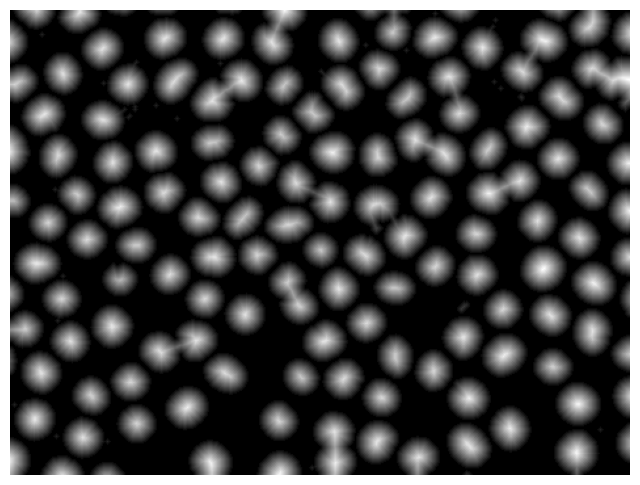

In [14]:
dist = cv.distanceTransform(filled, cv.DIST_L2, 3)

# Normalize the distance image for thresholding
cv.normalize(dist, dist, 0, 255.0, cv.NORM_MINMAX)
cvlib.imgview(dist)

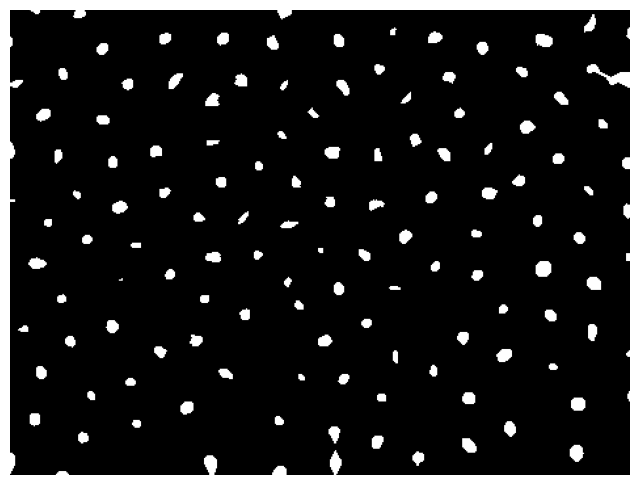

In [15]:
dist_bin = cv.threshold(dist,170,255,cv.THRESH_BINARY)[1]
dist_bin = dist_bin.astype(np.uint8)
cvlib.imgview(dist_bin)

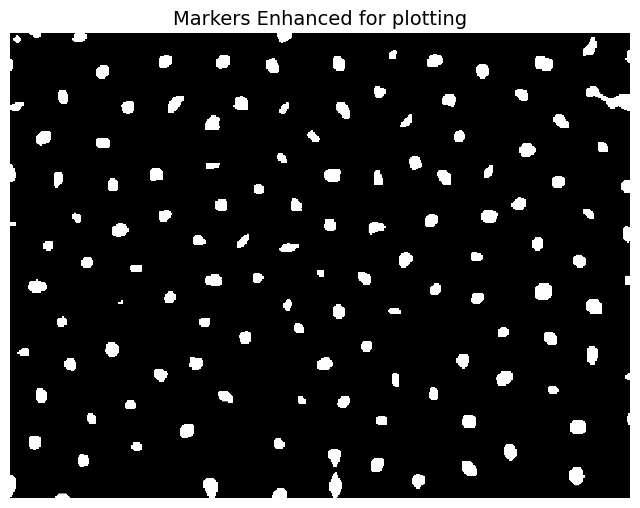

In [16]:
# Find total markers
contours, _ = cv.findContours(dist_bin, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
# Create the marker image for the watershed algorithm
markers = np.zeros(dist.shape, dtype=np.int32)

# Draw the foreground markers
for i in range(len(contours)):
    cv.drawContours(markers, contours, i, (i+1), -1)
    
# Draw the background marker
cv.circle(markers, (5,5), 2, (255,255,255), -1)
cvlib.imgview(markers*10000,title='Markers Enhanced for plotting')

In [32]:
# Perform the watershed algorithm
# Parameters:
# image	Input 8-bit 3-channel image.
# markers	Input/output 32-bit single-channel image (map) of markers. It should have the same size as image .

imgResult = img.copy()
imgResult = imgResult.astype(np.uint8)
markers = cv.watershed(imgResult, markers)

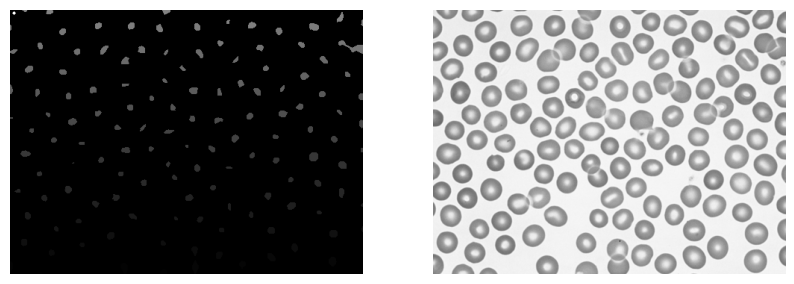

In [17]:
img[markers == -1] = [255,0,0]
cvlib.imgcmp(markers, img)

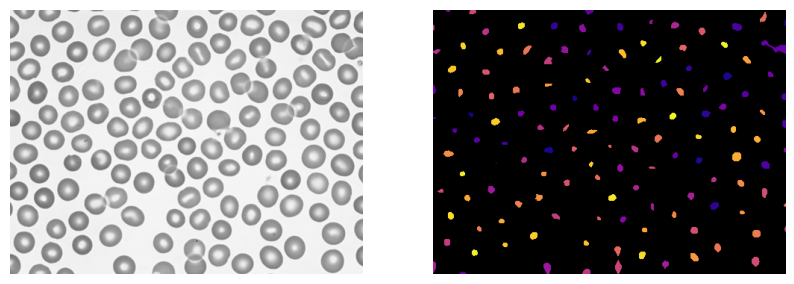

In [18]:
mark = markers.astype('uint8')
mark = cv.bitwise_not(mark)


import matplotlib
from matplotlib import cm
from random import shuffle

n_colors  = len(contours)
norm = matplotlib.colors.Normalize(vmin=0, vmax=(n_colors-1))
colors = []

for i in range(n_colors):
    colors.append(cm.plasma(norm(i),bytes=True))

shuffle(colors)

# Create the result image
dst = np.zeros((markers.shape[0], markers.shape[1], 3), dtype=np.uint8)

# Fill labeled objects with random colors
for i in range(markers.shape[0]):
    for j in range(markers.shape[1]):
        index = markers[i,j]
        if index > 0 and index <= len(contours):
            dst[i,j,:] = colors[index-1][:3]
            

cvlib.imgcmp(img, dst)